# Libiraries and Imports

In [ ]:
! pip install arabic-reshaper

In [ ]:
! pip install python-bidi

In [ ]:
import re
import string
import sys
import argparse
import json
import base64
import re
import argparse
from nltk.stem.isri import ISRIStemmer
import sys
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
import pandas
from sklearn.feature_selection import SelectKBest, chi2, f_classif
import pickle
import wordcloud
from wordcloud import WordCloud,STOPWORDS
import matplotlib.pyplot as plt
import arabic_reshaper
from bidi.algorithm import get_display

# Insert Data
Upload Excel Sheet of the reviews 
**Note (Prefered the column name is reviews)

In [ ]:
reviews_dataset = pandas.read_excel('/content/reviews.xlsx') #if you are working locally, you should put the diriectory to the excel sheet

In [ ]:
reviews_dataset

,reviews
0,اغلب الاغراض اللي احطها بالسله يكلمني المندوب ...
1,تطبيق سيء وأغلب الطلبات فيها مشاكل من المندوبين
2,تطبيق رائع بس يتاخر بالتوصيل
3,ياليت تضاف اسواق العثيم في هذا التطبيق الخاص ب...
4,تطبيق رائع من عدة تجارب
...,...
6167,Good but not the best
6168,"It is very nice, the delivery man, is good and..."
6169,Great application and excellent service keep i...
6170,"Overpriced, you will not get the same price as..."


# Preperation

## Removing Emojis and Sympols

In [ ]:
def remove_emoji(text):
    weridPatterns = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u'\U00010000-\U0010ffff'
                               u"\u200d"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\u3030"
                               u"\ufe0f"
                               u"\u2069"
                               u"\u2066"
                               u"\u200c"
                               u"\u2068"
                               u"\u2067"
                               "]+", flags=re.UNICODE)        
    return weridPatterns.sub(r'', text)

In [ ]:
reviews_dataset['reviews'] = reviews_dataset['reviews'].apply(lambda x: remove_emoji(x))

## Language Detection

In [ ]:
!pip install langdetect

In [ ]:
import langdetect

In [ ]:
def detect_lang(string):
    try:
        language = langdetect.detect(string)
    except:
        language = "error"
    return language

In [ ]:
reviews_dataset['detected Language'] = reviews_dataset['reviews'].apply(lambda x: detect_lang(x))

In [ ]:
reviews_dataset

,reviews,detected Language
0,اغلب الاغراض اللي احطها بالسله يكلمني المندوب ...,ar
1,تطبيق سيء وأغلب الطلبات فيها مشاكل من المندوبين,ar
2,تطبيق رائع بس يتاخر بالتوصيل,ar
3,ياليت تضاف اسواق العثيم في هذا التطبيق الخاص ب...,ar
4,تطبيق رائع من عدة تجارب,ar
...,...,...
6167,Good but not the best,en
6168,"It is very nice, the delivery man, is good and...",en
6169,Great application and excellent service keep i...,en
6170,"Overpriced, you will not get the same price as...",en


## Seperating Dataset to English and Arabic

In [ ]:
reviews_dataset_en = reviews_dataset[(reviews_dataset['detected Language'] == 'en')]

In [ ]:
reviews_dataset_ar = reviews_dataset[(reviews_dataset['detected Language'] == 'ar')]

In [ ]:
reviews_dataset_ar

,reviews,detected Language
0,اغلب الاغراض اللي احطها بالسله يكلمني المندوب ...,ar
1,تطبيق سيء وأغلب الطلبات فيها مشاكل من المندوبين,ar
2,تطبيق رائع بس يتاخر بالتوصيل,ar
3,ياليت تضاف اسواق العثيم في هذا التطبيق الخاص ب...,ar
4,تطبيق رائع من عدة تجارب,ar
...,...,...
5481,اتعامل مع نعناع واشعر بالراحة والرضى من بذلهم ...,ar
5482,أسواق المزرعه اطلب من عروض وعند توصيل وتسوق با...,ar
5483,مميز,ar
5824,"Not good services, delay on delivery time and ...",ar


# Arabic Reviews Analysis

## Text Preprocession
*   Stemming and Limitization
*   Remove punctuations and diacitics

In [ ]:
! pip install stop-words

In [ ]:
from stop_words import get_stop_words
stop_words_ar = get_stop_words('ar')
stop_words_en = get_stop_words('en')

In [ ]:
arabic_diacritics = re.compile("""
                             ّ    | # Tashdid
                             َ    | # Fatha
                             ً    | # Tanwin Fath
                             ُ    | # Damma
                             ٌ    | # Tanwin Damm
                             ِ    | # Kasra
                             ٍ    | # Tanwin Kasr
                             ْ    | # Sukun
                             ـ     # Tatwil/Kashida
                         """, re.VERBOSE)

arabic_punctuations = '''`÷×؛<>_()*&^%][ـ،/:"؟.,'{}~¦+|!”…“–ـ'''
english_punctuations = string.punctuation
punctuations_list = arabic_punctuations + english_punctuations

In [ ]:
def normalize_arabic(text):
    text = re.sub("[إأآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "ء", text)
    text = re.sub("ئ", "ء", text)
    text = re.sub("ة", "ه", text)
    text = re.sub("گ", "ك", text)
    return text


def remove_diacritics(text):
    text = re.sub(arabic_diacritics, '', text)
    return text


def remove_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)


def remove_repeating_char(text):
    return re.sub(r'(.)\1+', r'\1', text)

In [ ]:
def light_stem(text):
    words = text.split()
    result = list()
    stemmer = ISRIStemmer()
    for word in words:
        word = stemmer.norm(word, num=1)      # remove diacritics which representing Arabic short vowels
        if not word in stemmer.stop_words:    # exclude stop words from being processed
            word = stemmer.pre32(word)        # remove length three and length two prefixes in this order
            word = stemmer.suf32(word)        # remove length three and length two suffixes in this order
            word = stemmer.waw(word)          # remove connective ‘و’ if it precedes a word beginning with ‘و’
            word = stemmer.norm(word, num=2)  # normalize initial hamza to bare alif
        result.append(word)
    return ' '.join(result)

In [ ]:
#remove stopwords
def remove_stopwords(text):
    from stop_words import get_stop_words
    text_words = text.split()
    stop_words_ar = get_stop_words('ar')
    List_arabic_added_stopwords = ["ممتازة","ممتازه","من","فيه","في","جدا","حتى","بس","لكم","ياليت","ولكن","ليه","اللي","لي","ولكن","وانا"]
    stop_words_ar.extend(List_arabic_added_stopwords)
    resultwords  = [word for word in text_words if word.lower() not in stop_words_ar]
    result = ' '.join(resultwords)   
    return result

In [ ]:
reviews_dataset_ar['reviews'] = reviews_dataset_ar['reviews'].apply(lambda x: remove_diacritics(x))
reviews_dataset_ar['reviews'] = reviews_dataset_ar['reviews'].apply(lambda x: remove_punctuations(x))
reviews_dataset_ar['reviews'] = reviews_dataset_ar['reviews'].apply(lambda x: light_stem(x))
reviews_dataset_ar['reviews'] = reviews_dataset_ar['reviews'].apply(lambda x: remove_stopwords(x))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [ ]:
reviews_dataset_ar

,reviews,detected Language
0,اغلب اغراض احط سله يكلم مندوب يقول مو متوفره م...,ar
1,تطبيق سيء وأغلب طلب مشاكل مندوب,ar
2,تطبيق رائع يتاخر توصيل,ar
3,تضاف اسواق عثيم تطبيق خاص ببريده,ar
4,تطبيق رائع تجارب,ar
...,...,...
5481,اتعامل نعناع واشعر راحة رضى بذل جهود جبارة انج...,ar
5482,اسواق مزرعه اطلب عروض وعند توصيل وتسوق غربه يت...,ar
5483,مميز,ar
5824,Not good services delay on delivery time and n...,ar


## Model Load

In [ ]:
loaded_model_ar = pickle.load(open('/content/ar_finalized_model.sav', 'rb')) #if you are working locally, you should provide the model directory

In [ ]:
pred_ar = loaded_model_ar.predict(reviews_dataset_ar['reviews'])

## Arabic Reviews Results

In [ ]:
reviews_dataset_ar['satisfaction'] = pred_ar

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
reviews_dataset_ar

,reviews,detected Language,satisfaction
0,اغلب اغراض احط سله يكلم مندوب يقول مو متوفره م...,ar,dissatisfied
1,تطبيق سيء وأغلب طلب مشاكل مندوب,ar,dissatisfied
2,تطبيق رائع يتاخر توصيل,ar,satisfied
3,تضاف اسواق عثيم تطبيق خاص ببريده,ar,satisfied
4,تطبيق رائع تجارب,ar,satisfied
...,...,...,...
5481,اتعامل نعناع واشعر راحة رضى بذل جهود جبارة انج...,ar,satisfied
5482,اسواق مزرعه اطلب عروض وعند توصيل وتسوق غربه يت...,ar,neutral
5483,مميز,ar,satisfied
5824,Not good services delay on delivery time and n...,ar,dissatisfied


# English Reviews Analysis

## Model Load

In [ ]:
loaded_model_en = pickle.load(open('/content/en_finalized_model.sav', 'rb')) #if you are working locally, you should provide the model directory

In [ ]:
pred_en = loaded_model_en.predict(reviews_dataset_en['reviews'])

In [ ]:
reviews_dataset_en['satisfaction'] = pred_en

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
reviews_dataset_en

,reviews,detected Language,satisfaction
5484,With my last order I have delivery that wasn’t...,en,dissatisfied
5485,Often we do not find the item in the store,en,dissatisfied
5486,Worldwide promote your apps and rapidly increa...,en,satisfied
5487,Shopping list need to be updated,en,dissatisfied
5488,They have technical issues with online payment...,en,dissatisfied
...,...,...,...
6167,Good but not the best,en,satisfied
6168,"It is very nice, the delivery man, is good and...",en,neutral
6169,Great application and excellent service keep i...,en,satisfied
6170,"Overpriced, you will not get the same price as...",en,dissatisfied


# Save Results
Save Results to Excel Sheet
*   Arabic Reviews
*   English Reviews



In [ ]:
reviews_dataset_ar.to_excel(r"/content/Arabic Reviews Result.xlsx") #if you are working locally, save it to the directory you want
reviews_dataset_en.to_excel(r"/content/English Reviews Result.xlsx")#if you are working locally, save it to the directory you want

# Statistics
*   How many users are satisfied or not?
*   Why are they satisfied or not?



## Arabic Results

### How many are Satisfied?

In [ ]:
satisfied_ar = reviews_dataset_ar[(reviews_dataset_ar['satisfaction'] == 'satisfied')]

In [ ]:
satisfied_ar

,reviews,detected Language,satisfaction
2,تطبيق رائع يتاخر توصيل,ar,satisfied
3,تضاف اسواق عثيم تطبيق خاص ببريده,ar,satisfied
4,تطبيق رائع تجارب,ar,satisfied
8,افضل تطبيق,ar,satisfied
9,فعلا يستحق هل تطبيق,ar,satisfied
...,...,...,...
5478,تطبيق جميل نفسي مده معا وصراحه محترم وخدمه سريعه,ar,satisfied
5479,رائع,ar,satisfied
5480,لايصلح ابلكش افضل بكثيركل مأكتب ايميل يقول ايم...,ar,satisfied
5481,اتعامل نعناع واشعر راحة رضى بذل جهود جبارة انج...,ar,satisfied


### How many are Dissatisfied?

In [ ]:
dissatisfied_ar = reviews_dataset_ar[(reviews_dataset_ar['satisfaction'] == 'dissatisfied')]

In [ ]:
dissatisfied_ar

,reviews,detected Language,satisfaction
0,اغلب اغراض احط سله يكلم مندوب يقول مو متوفره م...,ar,dissatisfied
1,تطبيق سيء وأغلب طلب مشاكل مندوب,ar,dissatisfied
5,يظهر متاجر رغم اني بمنطقة حولي كلها متاجر,ar,dissatisfied
7,تطبيق جيد سيء نفس وقتجيد مقاضي لان طلبت مرة وا...,ar,dissatisfied
12,اختفاء متاجر موقع طائف مشكلة شهر,ar,dissatisfied
...,...,...,...
5474,اعطيته نجمه لاجل اعلق تصميم برنامج فاشل استطع ...,ar,dissatisfied
5475,سيء تلاعب اسعار سعر موجود ابلكيشن سعر فاتورة ف...,ar,dissatisfied
5477,كتطبيق جيد ومختلف حقيقه خدمات تفتقد احترافيه م...,ar,dissatisfied
5824,Not good services delay on delivery time and n...,ar,dissatisfied


### Why?

#### Satisfied Word Cloud

In [ ]:
serial_satisfied_ar = ' '.join(satisfied_ar['reviews'])
reshaped_satisfied_ar = arabic_reshaper.reshape(serial_satisfied_ar)
display_satisfied_ar = get_display(reshaped_satisfied_ar)

In [ ]:
font_file ='/content/NotoNaskhArabic-Regular.ttf' 
word_cloud_satisfied_ar = WordCloud(font_path=font_file, background_color='white',mode='RGB', width=2000, height=1000, repeat=False, collocations=False).generate(display_satisfied_ar)

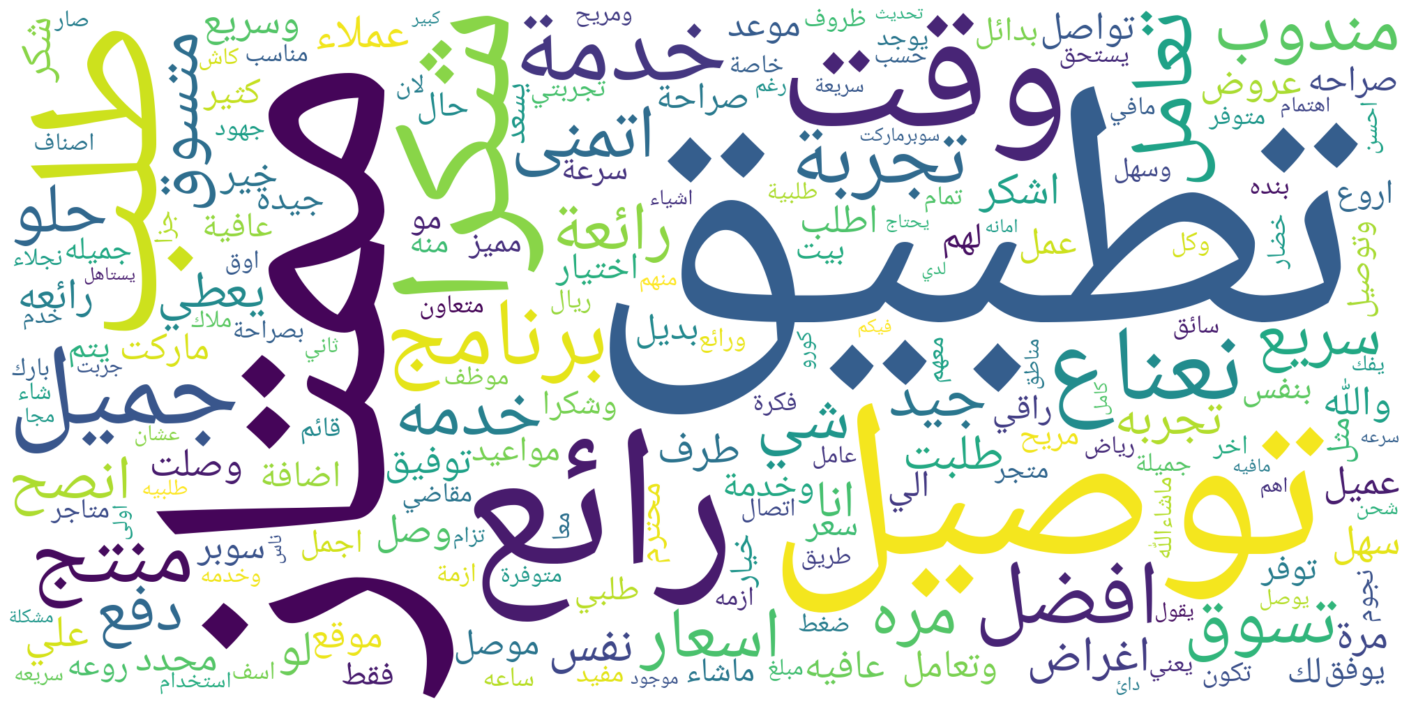

In [ ]:
plt.figure(figsize=(25,25))
plt.imshow(word_cloud_satisfied_ar, interpolation="bilinear")
plt.axis("off")

#Show the wordcloud
plt.show()

In [ ]:
word_cloud_satisfied_ar.to_file("word_cloud_satisfied_ar.png")

#### Dissatisfied Word Cloud

In [ ]:
serial_dissatisfied_ar = ' '.join(dissatisfied_ar['reviews'])
reshaped_dissatisfied_ar = arabic_reshaper.reshape(serial_dissatisfied_ar)
display_dissatisfied_ar = get_display(reshaped_dissatisfied_ar)

In [ ]:
font_file ='/content/NotoNaskhArabic-Regular.ttf' 
word_cloud_dissatisfied_ar = WordCloud(font_path=font_file, background_color='white',mode='RGB', width=2000, height=1000).generate(display_dissatisfied_ar)

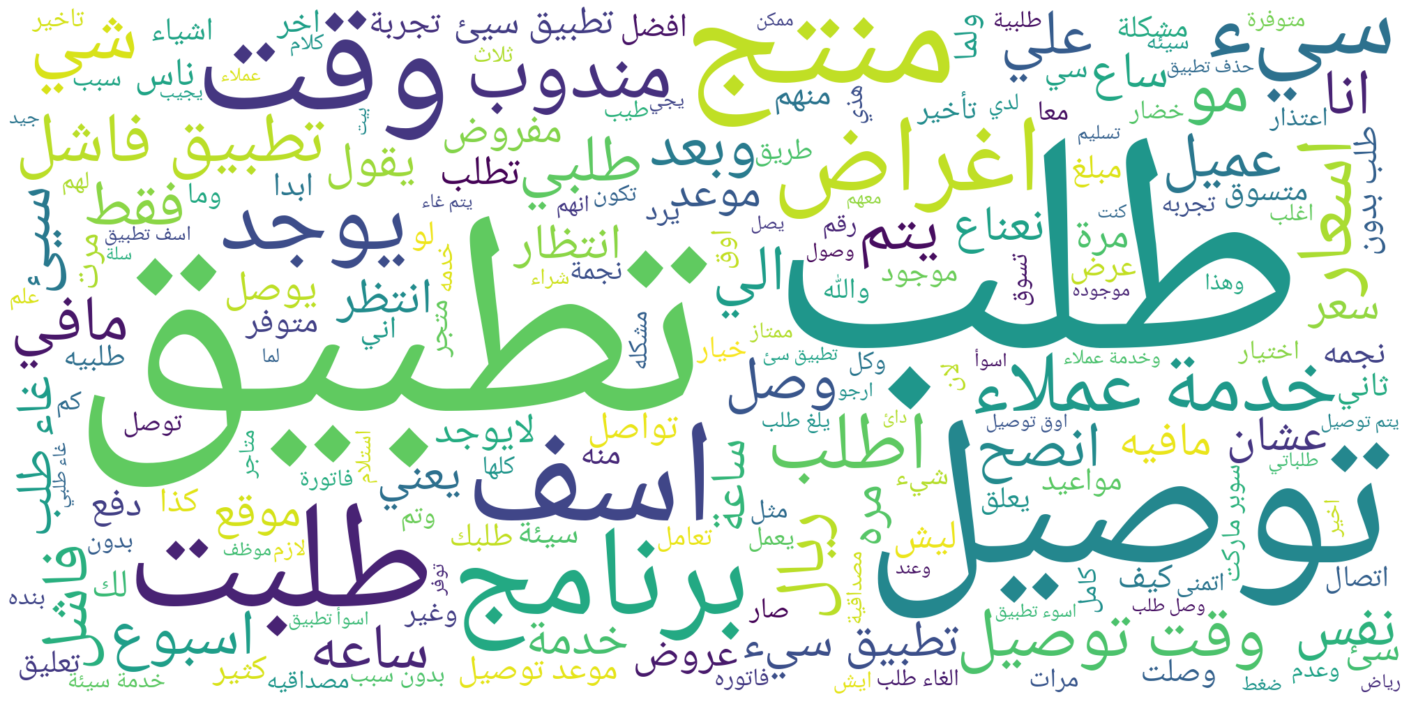

In [ ]:
plt.figure(figsize=(25,25))
plt.imshow(word_cloud_dissatisfied_ar, interpolation="bilinear")
plt.axis("off")

#Show the wordcloud
plt.show()

In [ ]:
word_cloud_dissatisfied_ar.to_file("word_cloud_dissatisfied_ar.png")

## English Results

### How many are Satisfied?

In [ ]:
satisfied_en = reviews_dataset_en[(reviews_dataset_en['satisfaction'] == 'satisfied')]

In [ ]:
satisfied_en

,reviews,detected Language,satisfaction
5486,Worldwide promote your apps and rapidly increa...,en,satisfied
5489,Thank you for on time delivery and good servic...,en,satisfied
5491,"service, daily installs can reach 3000+. Ping ...",en,satisfied
5495,Great app,en,satisfied
5503,Very authentic and on time delivery,en,satisfied
...,...,...,...
6162,2 times i ordered from hyperpanda from the app...,en,satisfied
6163,Very good consumer service. Very helpful.,en,satisfied
6165,Perfect,en,satisfied
6167,Good but not the best,en,satisfied


### How many are Dissatisfied?

In [ ]:
dissatisfied_en = reviews_dataset_en[(reviews_dataset_en['satisfaction'] == 'dissatisfied')]

In [ ]:
dissatisfied_en

,reviews,detected Language,satisfaction
5484,With my last order I have delivery that wasn’t...,en,dissatisfied
5485,Often we do not find the item in the store,en,dissatisfied
5487,Shopping list need to be updated,en,dissatisfied
5488,They have technical issues with online payment...,en,dissatisfied
5490,Sure the app is making our lives easier But wh...,en,dissatisfied
...,...,...,...
6157,"I choosed order to be between 20-01 hours, but...",en,dissatisfied
6164,The app is ok... but the problem once the the ...,en,dissatisfied
6166,Not good service even i you buy more than 100 ...,en,dissatisfied
6170,"Overpriced, you will not get the same price as...",en,dissatisfied


### Why?

#### Satisfied Word Cloud

In [ ]:
word_cloud_satisfied_en = WordCloud(background_color='white',mode='RGB', width=2000, height=1000,collocations=False).generate(' '.join(satisfied_en['reviews']))

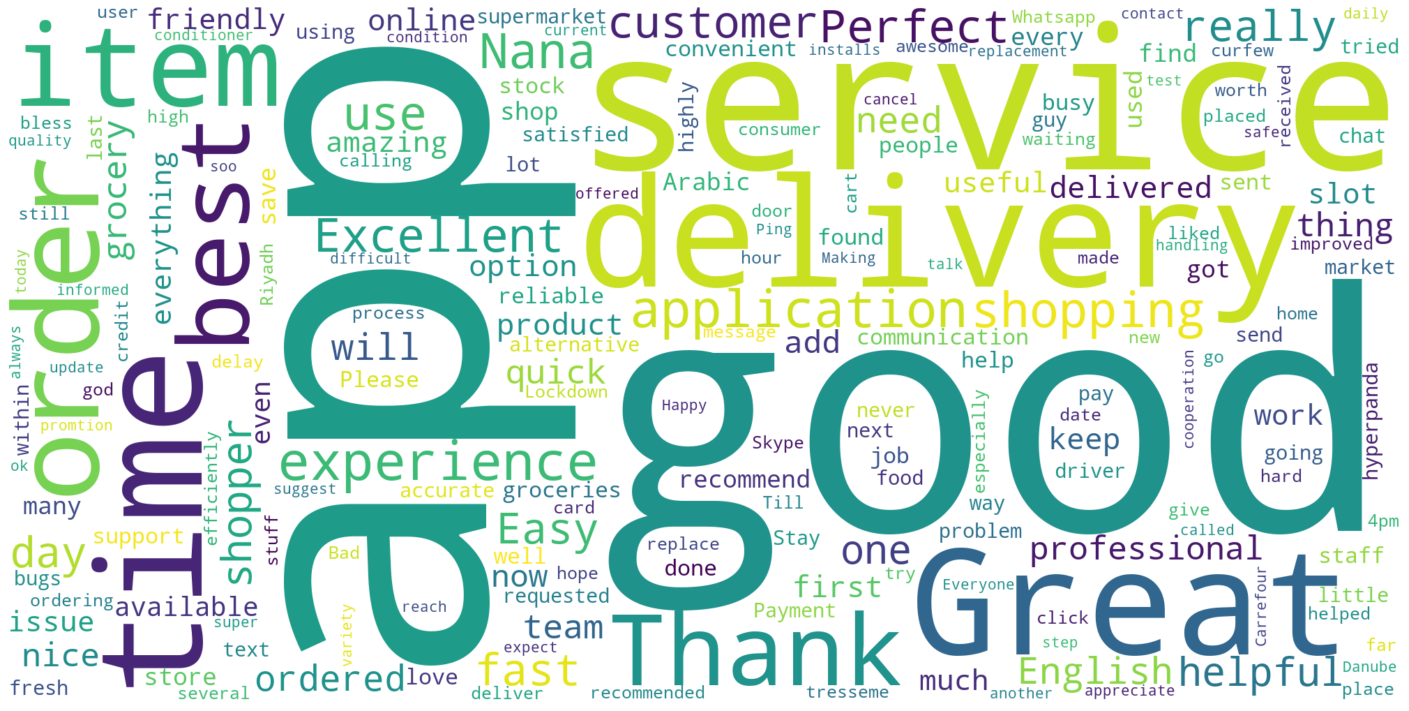

In [ ]:
plt.figure(figsize=(25,25))
plt.imshow(word_cloud_satisfied_en, interpolation="bilinear")
plt.axis("off")

#Show the wordcloud
plt.show()

In [ ]:
word_cloud_satisfied_en.to_file("word_cloud_satisfied_en.png")

#### Dissatisfied Word Cloud

In [ ]:
word_cloud_dissatisfied_en = WordCloud(background_color='white',mode='RGB', width=2000, height=1000).generate(' '.join(dissatisfied_en['reviews']))

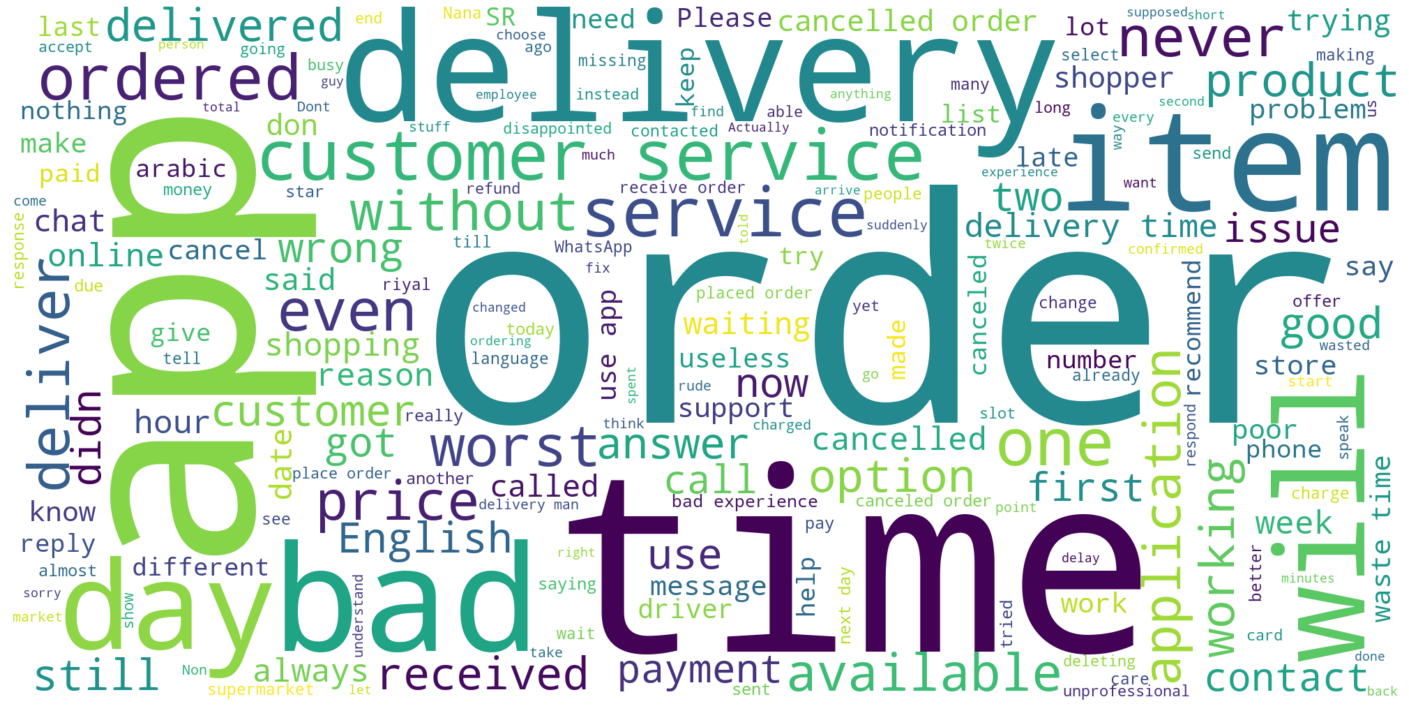

In [ ]:
plt.figure(figsize=(25,25))
plt.imshow(word_cloud_dissatisfied_en, interpolation="bilinear")
plt.axis("off")

#Show the wordcloud
plt.show()

In [ ]:
word_cloud_dissatisfied_en.to_file("word_cloud_dissatisfied_en.png")

In [ ]:
satisfied_ar.to_excel(r"/content/Arabic Reviews Satisfied Users.xlsx") #if you are working locally, save it to the directory you want
dissatisfied_ar.to_excel(r"/content/Arabic Reviews Dissatisfied Users.xlsx")#if you are working locally, save it to the directory you want
satisfied_en.to_excel(r"/content/English Reviews Satisfied Users.xlsx") #if you are working locally, save it to the directory you want
dissatisfied_en.to_excel(r"/content/English Reviews Disatisfied Users.xlsx")#if you are working locally, save it to the directory you want